# C&W Attack
[Carlini and Wagner, “Towards Evaluating the Robustness of Neural Networks”](https://arxiv.org/abs/1608.04644).

# 1. 事前準備と確認

## 必要なライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

## MNIST 用のモデルをロード

In [3]:
model = keras.models.load_model('../../models/mnist.h5')

## MNIST 用のモデル（logits版）をロード

In [4]:
model_logits = keras.models.load_model('../../models/mnist_logits.h5')

## MNIST データの取得とスケール変換

In [5]:
# MNIST データを Keras を使って取得
_, (X_test, Y_test) = keras.datasets.mnist.load_data()

# 0-1 スケールに変換
X_test = X_test/255.0

11493376/11490434 [==============================] - 1s 0us/step


## オリジナル画像の取得と表示

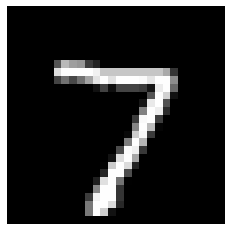

In [6]:
original_image = X_test[0]
plt.axis('off')
plt.imshow(original_image, cmap=plt.cm.gray)

## オリジナル画像のスコアと分類結果の表示 (model)

In [7]:
Y_hat = model.predict(np.expand_dims(original_image, 0)) # 推論結果
original_class = np.argmax(Y_hat, axis=1)[0] # 分類結果
original_score = np.max(Y_hat, axis=1)[0] # スコア

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(original_class, original_score * 100))

Prediction: 7 - score 99.91%


## オリジナル画像の logit と分類結果の表示 (model_logits)

In [8]:
logits = model_logits.predict(np.expand_dims(original_image, 0)) # logits
original_class_logits = np.argmax(logits, axis=1)[0] # 分類結果
original_logit = np.max(logits, axis=1)[0] # オリジナルクラスの logit

# 分類結果と logit を表示
print('Prediction: {0} - logit {1:.2f}'.format(original_class_logits, original_logit))

Prediction: 7 - logit 12.28


# 2. CW2 クラス開発

## CW2 クラス開発

In [9]:
class CW2:
    """ C&W Attack (L2) による敵対的サンプルを生成
    Attributes:
        classifier (Model) : logits を出力するモデル
        k (float): 自信を調整するパラメータ
        learning_rate (float): Adam の学習率
        binary_search_steps (int): バイナリサーチの回数
        max_iterations (int): Adam の最大イテレーション回数
        initial_c (float): c の初期値
    """

    def __init__(self, classifier, k = 0, learning_rate = 0.01,
                            binary_search_steps = 9, max_iterations = 1000,
                            initial_c = 0.001):

        # 引数をすべてインスタンス変数にセット
        self.classifier = classifier
        self.k = k
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.binary_search_steps = binary_search_steps
        self.initial_c = initial_c
            
    def is_satisfied_with_k(self, logits, target_class):
        """
        「 k を加味したターゲットクラスの logit が最大」という制約を満たすか確認する。
        ターゲットクラスの logit から k　を引いた値が他のどのクラスの logit よりも大きければ　True を返し、
        そうでなければ、False を返す。
        Args:
            logits (ndarray): logits
            target_class (ndarray): ターゲットクラス
        Returns:
            satisfied (bool): 制約を満たす場合は True、そうでなければ False
        """
        logits = np.copy(logits)
        logits[target_class] -= self.k
        satisfied = np.argmax(logits) == target_class
        return satisfied    
    
    def generate(self, original_image, target_class_ohe):
        """
        敵対的サンプルを生成
        Args:
            original_image (ndarray): オリジナル画像 `(28, 28)`
            target_class_ohe (ndarray): ターゲットクラスの One-Hot `(10, )`
        Returns:
            o_best_adv_image (ndarray): 敵対的サンプル `(28, 28)`
        """

        # ターゲットクラスを変数にセット
        target_class = np.argmax(target_class_ohe)
        
        # オリジナル画像の型を変数にセット
        shape = original_image.shape
               
        # c とその下限値と上限値をセット
        c = self.initial_c
        c_lower = 0
        c_upper = 1e10

        #  (tanh(w) + 1) / 2 の w
        w = tf.Variable(np.zeros(shape, dtype=np.float32))
        
        #  オリジナル画像を Tensor にキャスト
        original_imgae = tf.cast(original_image, dtype=tf.float32)

        # 目的関数を生成する
        def build_objective():

            # 敵対的サンプルを格納する変数
            adv_image = (tf.tanh(w) + 1) / 2

            # 目的関数1
            objective1 = tf.reduce_sum(tf.square(adv_image - original_image))

            # 敵対的サンプルの logits
            logits = self.classifier(tf.expand_dims(adv_image, axis=0))[0]

            # ターゲットクラスの logit
            target_logit = tf.reduce_sum(target_class_ohe * logits)
            
            # ターゲットクラス以外の logit の最大値
            other_max_logit = tf.reduce_max((1 - target_class_ohe) * logits + (target_class_ohe * np.min(logits)))
          
            # 目的関数2
            objective2 = c * tf.maximum(0.0, other_max_logit - target_logit + self.k)

            # 目的関数
            objective = objective1 + objective2

            return objective

        # 目的関数を呼び出し可能な(callable)オブジェクトとしてセット
        objective = lambda: build_objective()
        
        # 目的関数の最小化の過程で見つかった最小の objective1、敵対的サンプル、分類結果を格納する変数
        o_best_objective1 = np.inf # 初期値として無限をセット
        o_best_adv_image = np.zeros(shape) # 初期値としてすべての要素に0をセット
        o_best_class = -1 # 初期値としてダミークラスをセット
        
        # バイナリサーチ用のループ
        for outer_step in range(self.binary_search_steps):
            
            # バイナリサーチのステップ内で見つかった最小の objective1 と分類結果を格納する変数
            best_objective1 = np.inf # 初期値として無限をセット
            best_class = -1 # 初期値としてダミークラスをセット
            
            # objective を保存しておく変数
            prev_objective = np.inf # 初期値として無限をセット
            
            # Adam のインスタンスを生成
            opt = keras.optimizers.Adam(self.learning_rate)
            
            # Adam を実行するループ
            for iteration in range(self.max_iterations):
                
                # Adam を実行
                opt.minimize(objective, var_list=[w])
                
                # 敵対的サンプルの logits 取得
                adv_image = (tf.tanh(w) + 1) / 2
                logits = self.classifier(tf.expand_dims(adv_image, axis=0))[0]

                objective1 = tf.reduce_sum(tf.square(adv_image - original_image))

                # max_iterations の 10% ごとに objective を確認
                if iteration % (self.max_iterations // 10) == 0:
                    # objective にほとんど変化がない、もしくは増えている場合は Adam のループを抜ける
                    if objective() > prev_objective * 0.9999:
                        break
                    # 次のステップの比較用に現在の objective を保存
                    prev_objective = objective()
                
                # 制約を満たすか確認
                satisfied = self.is_satisfied_with_k(logits, target_class)

                # objective1 が、best_objective1 より小さく、制約も満たせば、best_objective1 と best_class を更新する
                if objective1 < best_objective1 and satisfied:
                    best_objective1 = objective1
                    best_class = target_class
                    
                # objective1 が、o_best_objective1 より小さく、制約も満たせば、o_best_objective1, o_best_class, o_best_adv_image を更新する
                if objective1 < o_best_objective1 and satisfied:
                    o_best_objective1 = objective1
                    o_best_class = target_class
                    o_best_adv_image = adv_image

            # 現在のバイナリサーチのステップで制約を満たしている場合
            if best_class == target_class:
                # c の上限値に現在の c をセットする
                c_upper = c

                # c に　「現在の c」　と　「c の下限値」　の平均値をセットする
                c = (c_lower + c_upper) / 2

            # 見つからなかった場合
            else:
                # c の下限値に現在の c をセットする
                c_lower = c
                if c_upper < 1e9:
                    # c の上限値が 1e9 未満の場合は、c に　「現在の c」　と　「c の上限値」　の平均値をセットする
                    c = (c_lower + c_upper) / 2
                else:
                    # それ以外は、c が大きくなりすぎないように、c を 10 倍する
                    c *= 10
            
            # ログ出力
            print('Binary Search {0}/{1}'.format(outer_step + 1, self.binary_search_steps))
            print('  L2 square: {0:.2f} - c: {1:.2f} - class: {2}'.format(o_best_objective1, c, o_best_class))

        # 敵対的サンプルを ndarray に変換して返す
        return o_best_adv_image.numpy()

# 3. 攻撃

## ターゲットクラスの One-Hot を生成

In [10]:
target_class_ohe = to_categorical(0, num_classes=10) # ターゲットクラスを 0 とする

## k = 0 で敵対的サンプルを生成

In [11]:
attack = CW2(model_logits, k=0) # k = 0 で CW2 のインスタンスを生成
adv_image_k0 = attack.generate(original_image, target_class_ohe) # 敵対的サンプルを生成

Binary Search 1/9
  L2 square: inf - c: 0.01 - class: -1
Binary Search 2/9
  L2 square: inf - c: 0.10 - class: -1
Binary Search 3/9
  L2 square: inf - c: 1.00 - class: -1
Binary Search 4/9
  L2 square: 1.77 - c: 0.55 - class: 0
Binary Search 5/9
  L2 square: 1.76 - c: 0.33 - class: 0
Binary Search 6/9
  L2 square: 1.76 - c: 0.44 - class: 0
Binary Search 7/9
  L2 square: 1.76 - c: 0.38 - class: 0
Binary Search 8/9
  L2 square: 1.76 - c: 0.41 - class: 0
Binary Search 9/9
  L2 square: 1.76 - c: 0.40 - class: 0


## k = 0 の敵対的サンプルによる攻撃と敵対的サンプルの表示

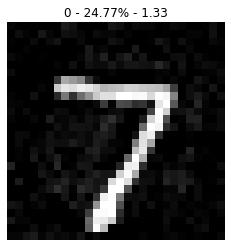

In [12]:
# 推論結果。 model_logits ではなく、model での推論である点に注意
Y_hat_k0 = model.predict(np.expand_dims(adv_image_k0, 0))

# スコア
score_k0 = np.max(Y_hat_k0[0])

# 分類結果
class_k0 = np.argmax(Y_hat_k0[0])

# L2
L2_k0 = np.linalg.norm(adv_image_k0 - original_image)

# 敵対的サンプルを表示
plt.axis('off')
plt.title('{0} - {1:.2f}% - {2:.2f}'.format(class_k0, score_k0 * 100, L2_k0))
plt.imshow(adv_image_k0, cmap=plt.cm.gray)

## k = 7 で敵対的サンプルを生成

In [13]:
attack = CW2(model_logits, k=7) # k = 7 で CW2 のインスタンスを生成
adv_image_k7 = attack.generate(original_image, target_class_ohe)

Binary Search 1/9
  L2 square: inf - c: 0.01 - class: -1
Binary Search 2/9
  L2 square: inf - c: 0.10 - class: -1
Binary Search 3/9
  L2 square: inf - c: 1.00 - class: -1
Binary Search 4/9
  L2 square: inf - c: 10.00 - class: -1
Binary Search 5/9
  L2 square: 6.85 - c: 5.50 - class: 0
Binary Search 6/9
  L2 square: 6.81 - c: 3.25 - class: 0
Binary Search 7/9
  L2 square: 6.81 - c: 2.12 - class: 0
Binary Search 8/9
  L2 square: 6.79 - c: 1.56 - class: 0
Binary Search 9/9
  L2 square: 6.78 - c: 1.28 - class: 0


## k = 7 の敵対的サンプルによる攻撃と敵対的サンプルの表示

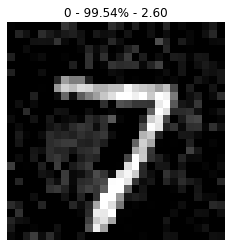

In [14]:
# 推論結果。 model_logits ではなく、model での推論である点に注意
Y_hat_k7 = model.predict(np.expand_dims(adv_image_k7, 0))

# スコア
score_k7 = np.max(Y_hat_k7[0])

# 分類結果
class_k7 = np.argmax(Y_hat_k7[0])

# L2
L2_k7 = np.linalg.norm(adv_image_k7 - original_image)

# 敵対的サンプルを表示
plt.axis('off')
plt.title('{0} - {1:.2f}% - {2:.2f}'.format(class_k0, score_k7 * 100, L2_k7))
plt.imshow(adv_image_k7, cmap=plt.cm.gray)

## 全て表示（cmap=plt.cm.binary）

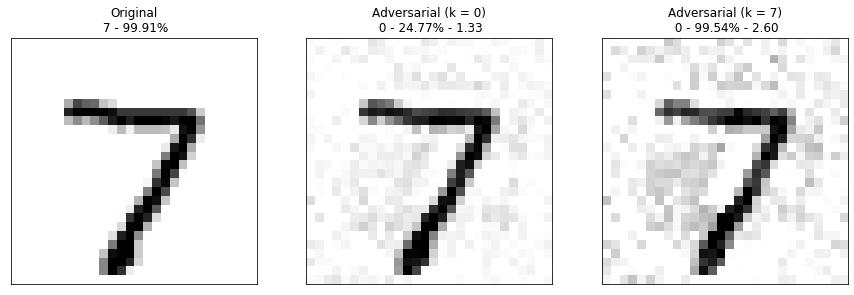

In [15]:
plt.figure(figsize=(15, 15))

# オリジナル画像を表示
plt.subplot(1, 3, 1)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.title('Original\n {0} - {1:.2f}%'.format(original_class, original_score * 100))
plt.imshow(original_image, cmap=plt.cm.binary)

# k = 0 の敵対的サンプルを表示
plt.subplot(1, 3, 2)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.title('Adversarial (k = 0)\n {0} - {1:.2f}% - {2:.2f}'.format(class_k0, score_k0 * 100, L2_k0))
plt.imshow(adv_image_k0, cmap=plt.cm.binary)

# k = 7 の敵対的サンプルを表示
plt.subplot(1, 3, 3)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.title('Adversarial (k = 7)\n {0} - {1:.2f}% - {2:.2f}'.format(class_k7, score_k7 * 100, L2_k7))
plt.imshow(adv_image_k7, cmap=plt.cm.binary)